In [2]:
%load_ext autoreload
%autoreload 2
import sys
print(sys.executable)
import pandas as pd
import numpy as np
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim
import statsmodels.api as sm

from signal_generator import synthesizer, synthesizer_builder
from signal_generator.synthesizer import Synthesizer
import importlib
from signal_generator.synthesizer_builder import SynthesizerBuilder
from models.deep_glm import BoldGLM
# from torchvision import datasets, transforms

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/opt/anaconda3/bin/python


## TODO

- Increase the Design matrix complexity (more confounds)
- Read more about syntheitc MRI signal generation
- Evaluate the optimizer and learning rate impacts
- Generate the hemodynamic response by hand
- Look into simulating multiple regions
- Think about how RNN could be used to learn the beta values (Could use a Recurrent CNN approach)

## Subject level GLM

In [3]:
# Baseline
# design_matrix = np.array([[ 1.00000000e+00,  0.00000000e+00,  9.07125285e-06,  4.67507768e-02],
#        [ 1.00000000e+00,  2.56410256e-01,  1.62184895e-05, -2.76890343e-02],
#        [ 1.00000000e+00,  5.12820513e-01,  2.74377012e-05, -2.44305850e-02],
#        [ 1.00000000e+00,  7.69230769e-01,  4.43304645e-05, -3.40362688e-03],
#        [ 1.00000000e+00,  1.02564103e+00,  6.88820865e-05,  8.40130664e-03],
#        [ 1.00000000e+00,  1.28205128e+00,  1.03489204e-04, -1.19617571e-02],
#        [ 1.00000000e+00,  1.53846154e+00,  1.50978958e-04,  1.42894120e-02],
#        [ 1.00000000e+00,  1.79487179e+00,  2.14620619e-04,  1.69790383e-02],
#        [ 1.00000000e+00,  2.05128205e+00,  2.98130484e-04,  7.58858876e-02],
#        [ 1.00000000e+00,  2.30769231e+00,  4.05670802e-04,  7.17081155e-02],
#        [ 1.00000000e+00,  2.56410256e+00,  5.41843416e-04,  1.13924093e-03],
#        [ 1.00000000e+00,  2.82051282e+00,  7.11678783e-04, -3.35078702e-02],
#        [ 1.00000000e+00,  3.07692308e+00,  9.20620952e-04, -4.47798884e-03],
#        [ 1.00000000e+00,  3.33333333e+00,  1.17450906e-03, -3.83506800e-02],
#        [ 1.00000000e+00,  3.58974359e+00,  1.47955587e-03, -5.67304245e-02],
#        [ 1.00000000e+00,  3.84615385e+00,  1.84232372e-03, -1.52736904e-01],
#        [ 1.00000000e+00,  4.10256410e+00,  2.26969848e-03, -4.54350655e-02],
#        [ 1.00000000e+00,  4.35897436e+00,  2.76886173e-03,  2.64821959e-02],
#        [ 1.00000000e+00,  4.61538462e+00,  3.34726162e-03,  5.29740884e-02],
#        [ 1.00000000e+00,  4.87179487e+00,  4.01258270e-03, -3.35900639e-02],
#        [ 1.00000000e+00,  5.12820513e+00,  4.77271503e-03, -1.00783236e-02],
#        [ 1.00000000e+00,  5.38461538e+00,  5.63572279e-03,  1.07335678e-01],
#        [ 1.00000000e+00,  5.64102564e+00,  6.60981270e-03, -1.74762378e-02],
#        [ 1.00000000e+00,  5.89743590e+00,  7.70330244e-03,  5.67315325e-02],
#        [ 1.00000000e+00,  6.15384615e+00,  8.92458922e-03,  2.73409977e-02],
#        [ 1.00000000e+00,  6.41025641e+00,  1.02821187e-02, -4.82420946e-02],
#        [ 1.00000000e+00,  6.66666667e+00,  1.17843546e-02,  5.69996052e-02],
#        [ 1.00000000e+00,  6.92307692e+00,  1.34397484e-02,  2.41827730e-02],
#        [ 1.00000000e+00,  7.17948718e+00,  1.52567109e-02, -4.30647624e-02],
#        [ 1.00000000e+00,  7.43589744e+00,  1.72435833e-02,  8.23359079e-03],
#        [ 1.00000000e+00,  7.69230769e+00,  1.94086104e-02, -2.62073996e-02],
#        [ 1.00000000e+00,  7.94871795e+00,  1.83686201e-02,  5.97903404e-03],
#        [ 1.00000000e+00,  8.20512821e+00,  1.71743687e-02,  5.81206115e-02],
#        [ 1.00000000e+00,  8.46153846e+00,  1.58100953e-02, -5.79510790e-02],
#        [ 1.00000000e+00,  8.71794872e+00,  1.42591893e-02,  5.50934857e-02],
#        [ 1.00000000e+00,  8.97435897e+00,  1.25041994e-02, -3.03788855e-02],
#        [ 1.00000000e+00,  9.23076923e+00,  1.05268452e-02,  2.03694016e-03],
#        [ 1.00000000e+00,  9.48717949e+00,  8.30803063e-03,  2.48877705e-02],
#        [ 1.00000000e+00,  9.74358974e+00,  5.82786109e-03,  8.78237695e-03],
#        [ 1.00000000e+00,  1.00000000e+01,  3.06566201e-03,  2.62156648e-02]])

# Noisy Design Matrix
design_matrix = np.array([[ 1.00000000e+00,  0.00000000e+00,  9.07125285e-06,  9.80364192e-03],
       [ 1.00000000e+00,  2.56410256e-01,  1.62184895e-05,  2.14882618e-01],
       [ 1.00000000e+00,  5.12820513e-01,  2.74377012e-05, -1.16218342e-01],
       [ 1.00000000e+00,  7.69230769e-01,  4.43304645e-05, -1.35166679e-01],
       [ 1.00000000e+00,  1.02564103e+00,  6.88820865e-05, -3.31156309e-03],
       [ 1.00000000e+00,  1.28205128e+00,  1.03489204e-04, -3.59697348e-01],
       [ 1.00000000e+00,  1.53846154e+00,  1.50978958e-04, -5.82338266e-02],
       [ 1.00000000e+00,  1.79487179e+00,  2.14620619e-04,  3.95926490e-01],
       [ 1.00000000e+00,  2.05128205e+00,  2.98130484e-04, -1.19023289e-01],
       [ 1.00000000e+00,  2.30769231e+00,  4.05670802e-04,  1.28218510e-01],
       [ 1.00000000e+00,  2.56410256e+00,  5.41843416e-04,  2.77085965e-01],
       [ 1.00000000e+00,  2.82051282e+00,  7.11678783e-04, -2.25577002e-01],
       [ 1.00000000e+00,  3.07692308e+00,  9.20620952e-04, -2.98853350e-01],
       [ 1.00000000e+00,  3.33333333e+00,  1.17450906e-03, -2.29277796e-01],
       [ 1.00000000e+00,  3.58974359e+00,  1.47955587e-03, -2.09512103e-02],
       [ 1.00000000e+00,  3.84615385e+00,  1.84232372e-03, -8.58695272e-02],
       [ 1.00000000e+00,  4.10256410e+00,  2.26969848e-03, -6.64428050e-02],
       [ 1.00000000e+00,  4.35897436e+00,  2.76886173e-03,  3.11571310e-02],
       [ 1.00000000e+00,  4.61538462e+00,  3.34726162e-03,  1.12554137e-01],
       [ 1.00000000e+00,  4.87179487e+00,  4.01258270e-03, -3.76123778e-01],
       [ 1.00000000e+00,  5.12820513e+00,  4.77271503e-03, -5.13667212e-01],
       [ 1.00000000e+00,  5.38461538e+00,  5.63572279e-03, -2.10386760e-01],
       [ 1.00000000e+00,  5.64102564e+00,  6.60981270e-03, -1.74099802e-01],
       [ 1.00000000e+00,  5.89743590e+00,  7.70330244e-03,  3.22965215e-02],
       [ 1.00000000e+00,  6.15384615e+00,  8.92458922e-03,  2.82319126e-01],
       [ 1.00000000e+00,  6.41025641e+00,  1.02821187e-02, -3.88299385e-01],
       [ 1.00000000e+00,  6.66666667e+00,  1.17843546e-02, -4.57326824e-02],
       [ 1.00000000e+00,  6.92307692e+00,  1.34397484e-02, -5.07181830e-02],
       [ 1.00000000e+00,  7.17948718e+00,  1.52567109e-02,  9.64526228e-02],
       [ 1.00000000e+00,  7.43589744e+00,  1.72435833e-02,  7.07497272e-02],
       [ 1.00000000e+00,  7.69230769e+00,  1.94086104e-02, -5.15144083e-01],
       [ 1.00000000e+00,  7.94871795e+00,  1.83686201e-02, -1.68272056e-01],
       [ 1.00000000e+00,  8.20512821e+00,  1.71743687e-02,  5.01083998e-02],
       [ 1.00000000e+00,  8.46153846e+00,  1.58100953e-02,  2.09052795e-01],
       [ 1.00000000e+00,  8.71794872e+00,  1.42591893e-02, -1.42146267e-01],
       [ 1.00000000e+00,  8.97435897e+00,  1.25041994e-02, -7.19001300e-02],
       [ 1.00000000e+00,  9.23076923e+00,  1.05268452e-02, -3.76992774e-01],
       [ 1.00000000e+00,  9.48717949e+00,  8.30803063e-03, -1.16162456e-01],
       [ 1.00000000e+00,  9.74358974e+00,  5.82786109e-03, -1.90408205e-01],
       [ 1.00000000e+00,  1.00000000e+01,  3.06566201e-03,  4.71441206e-02]])
print(design_matrix.shape)
beta_values_target = np.array([1, 2, 20, 0])
# print(design_matrix.shape, beta_values.shape)
y_true = np.dot(design_matrix, beta_values_target)
print("Y_true: ", y_true, type(y_true), y_true.shape)

(40, 4)
Y_true:  [ 1.00018143  1.51314488  2.02618978  2.53934815  3.0526597   3.56617234
  4.07994266  4.59403599  5.10852671  5.62349804  6.13904199  6.65525922
  7.17225858  7.69015684  8.2090783   8.72915417  9.25052217  9.77332595
 10.29771447 10.82384139 11.35186456 11.88194522 12.41424753 12.94893785
 13.48618408 14.02615519 14.56902043 15.11494881 15.66410858 16.21666655
 16.77278759 17.2648083  17.75374379 18.23927883 18.72108123 19.19880193
 19.67207536 20.14051959 20.6037367  21.06131324] <class 'numpy.ndarray'> (40,)


## Synthesize Brain Data

Signal shape:  (400, 1)
Design matrix:  (400, 3)


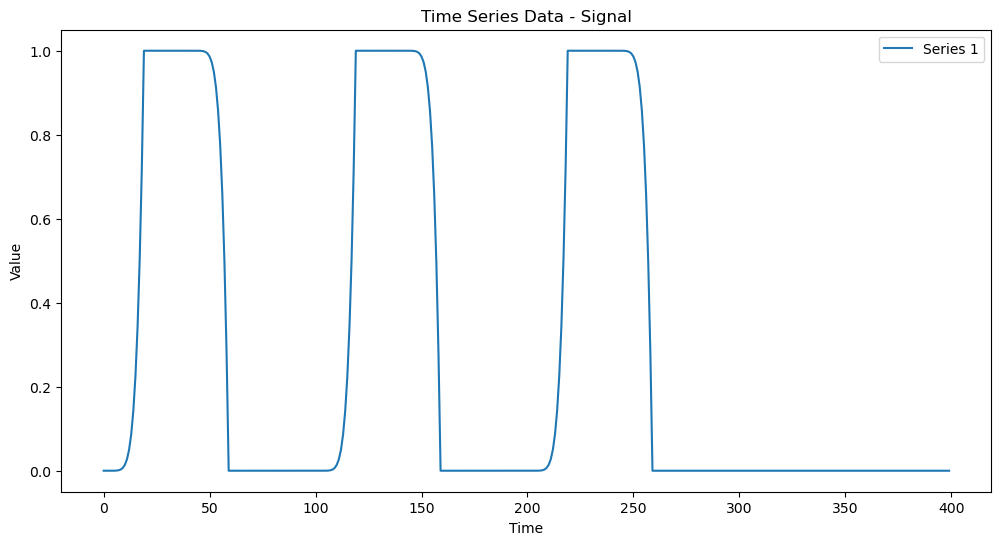

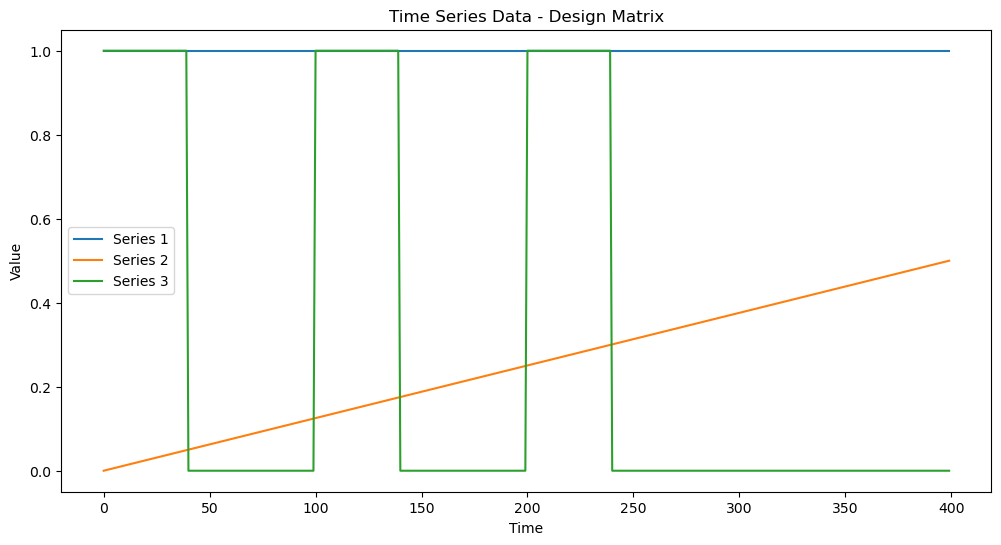

Y_true:  [13.         13.0018797  13.0037594  13.0056391  13.0075188  13.0093985
 13.0112782  13.01315789 13.01503759 13.01691729 13.01879699 13.02067669
 13.02255639 13.02443609 13.02631579 13.02819549 13.03007519 13.03195489
 13.03383459 13.03571429 13.03759398 13.03947368 13.04135338 13.04323308
 13.04511278 13.04699248 13.04887218 13.05075188 13.05263158 13.05451128
 13.05639098 13.05827068 13.06015038 13.06203008 13.06390977 13.06578947
 13.06766917 13.06954887 13.07142857 13.07330827  1.07518797  1.07706767
  1.07894737  1.08082707  1.08270677  1.08458647  1.08646617  1.08834586
  1.09022556  1.09210526  1.09398496  1.09586466  1.09774436  1.09962406
  1.10150376  1.10338346  1.10526316  1.10714286  1.10902256  1.11090226
  1.11278195  1.11466165  1.11654135  1.11842105  1.12030075  1.12218045
  1.12406015  1.12593985  1.12781955  1.12969925  1.13157895  1.13345865
  1.13533835  1.13721805  1.13909774  1.14097744  1.14285714  1.14473684
  1.14661654  1.14849624  1.15037594  1.152

In [9]:
%reload_ext autoreload
# Create a Synthesizer with custom parameters using the builder
synth_builder = SynthesizerBuilder()
synth = (synth_builder
       .add_length(400)
       .add_intercept()
       .add_drift(0, 0.5)
       .add_signal(40, 60, 3, "1")
       .build())
signal, design_matrix = synth.get()
print("Signal shape: ", signal.shape)
print("Design matrix: ", design_matrix.shape)
synth.plot_signal()
synth.plot_design_matrix()

# Get the GLM Values
beta_values_target = np.array([1, 1.5, 12])
# print(design_matrix.shape, beta_values.shape)
y_true = np.dot(design_matrix, beta_values_target)
print("Y_true: ", y_true, type(y_true), y_true.shape)

## Deep learning implementation

In [11]:
# Run the model
print(signal.shape)
# TODO - DESIGN MATRIX SHAPE SHOULD BE ()
model, losses = BoldGLM.train_bold_glm(design_matrix, y_true)

beta_values = model.get_betas()
print("Target: ", beta_values_target)
print("Learned: ", beta_values.flatten())

(400, 1)
(400, 3) (400,)
Target:  [ 1.   1.5 12. ]
Learned:  [ 1.000007  1.500007 12.000008]


## Prebuilt GLM

In [13]:
# Define and fit the GLM model
model = sm.GLM(y_true, design_matrix, family=sm.families.Gaussian())
results = model.fit()

# Output the summary of the model
print(results.summary())
print("Beta values: ", results.params)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  400
Model:                            GLM   Df Residuals:                      397
Model Family:                Gaussian   Df Model:                            2
Link Function:               Identity   Scale:                      4.7791e-29
Method:                          IRLS   Log-Likelihood:                 12693.
Date:                Thu, 14 Nov 2024   Deviance:                   6.4028e-27
Time:                        11:44:39   Pearson chi2:                 6.40e-27
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0000   8.87e-16   1.13e+15      0.0

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
